# Traffic Sign Recognition using Convolutional Neural Networks

**Group 2 members:** <br>
Bruno Belo, R20170735 <br>
Rui Monteiro, R20170796 <br>
Tomás Santos, R20170734 <br>

**MSc:** Data Science and Advanced Analytics - Nova IMS <br>
**Course:** Deep Learning <br>
2020/2021

## Introduction
For some years now, several companies like Tesla, Toyota, and Mercedes-Benz, to name a few, have been researching and creating Intelligent Systems for autonomous vehicles and self-driving cars. This is possible due to Artificial Intelligence or, more specifically, to the subset of Machine Learning called Deep Learning. For the driver to let the car drive itself autonomously, the vehicle needs to understand and follow all traffic rules; thus, it should be able to interpret traffic signs and make decisions accordingly.

When trying to follow all traffic rules, the systems are involved in two main phases: the first one, to detect traffic signs along the road, and the second one, to recognize them (if some were detected). Our Deep Learning project focuses on Phase 2, traffic sign recognition (in this case, with Convolutional Neural Networks).

The image data we used to feed the models is public and comes from the “GTSRB - German Traffic Sign Recognition Benchmark” competition in Kaggle. This is a multi-class, single-image classification challenge from the International Joint Conference on Neural Networks 2011.

This data includes more than 50 000 traffic signs’ images, and more than 40 classes. In fact, the dataset is quite varying, because some of the classes have many images while others have few.

We intend to build a model mainly using the Keras library on Python, and the data referenced above, in order to classify thousands of images with traffic signs into several different categories.

We found some people claiming to have models with Test accuracies between 95 and 98%, so our main goal for this task is to achieve a Test accuracy of around 97%, or more. Also, the complexity of our model and the time it takes to run in Python will be important factors for us.

## Data and Environment Setup
To run this Notebook without issues, the user can fork and clone our **GitHub repository** available at https://github.com/rfmmonteiro99/DL-Project-Final.

Also, the images for this Computer Vision project can be downloaded from Kaggle at https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign. The user should put this Notebook in the same folder as the data. Thus, one should have a folder with: 
- 3 other folders ("Meta", "Test" and "Train");
- this Jupyter Notebook;
- 3 Excel sheets (once again: "Meta", "Test" and "Train").

Furthermore, the user needs an Anaconda environment with all the used libraries. A yml file is provided on our GitHub repository (link above) for that purpose. The user can **create the environment** with the traffic_signs_env.yml file, by following these steps:
1. Put the yml file on a folder or even on the Desktop
2. Open Anaconda Navigator
3. Go to "Environments"
4. Click on "Import"
5. Name the new environment on "Name", and find the path to your file on "Specification File" (you may need to specify you want to search for txt files on the "Import Environment" box)
6. Click on "Import" so that Anaconda starts loading all the packages
7. Finally, navigate to the new environment on "Home" and launch Jupyter Notebook

In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Keras and TensorFlow:
import keras
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.regularizers import l1_l2
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from keras import optimizers
from keras.applications.vgg16 import VGG16
# the EfficientNet models are not available in some Keras versions at the moment, only on TensorFlow
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from keras.applications.resnet_v2 import ResNet152V2
from keras.models import Model

# scikit-learn:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

## 1. Importing and Exploring Data

In [2]:
data = []
labels = []
classes = 43
cur_path = os.getcwd()

# Retrieving the images and their labels 
for i in range(classes):
    path = os.path.join(cur_path,'train',str(i))
    images = os.listdir(path)

    for a in images:
        try:
            image = Image.open(path + '\\'+ a)
            image = image.resize((32,32)) # Resizing the images to 32x32
            image = np.array(image)
            data.append(image)
            labels.append(i)
            
        except:
            print('Error loading an image')

In [3]:
# Converting lists into Numpy arrays
data = np.array(data)
labels = np.array(labels)

In [4]:
# Check data shape (3 colour channels: Red, Green, Blue -> RGB)
print(data.shape, labels.shape)

(39209, 32, 32, 3) (39209,)


In [5]:
# Number of classes for this classification problem
unique_signs = np.unique(labels)

len(unique_signs)

43

In [6]:
# Dictionary with the labels of all traffic signs
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

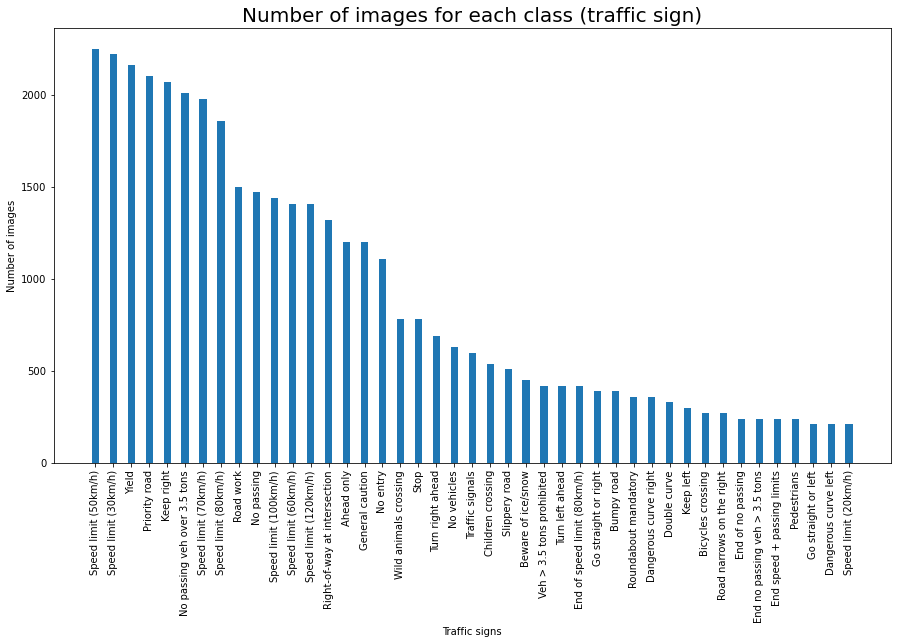

In [7]:
# Getting a list with the classes' names
signs_names = []

for i in range(len(classes)):
    signs_names.append(classes[i])

# Getting a df with the signs' names and the number of images per sign
data_df = {
   'labels': signs_names,
   'number_of_imgs': pd.Series(labels).value_counts().sort_index().to_list()
}

bar_df = pd.DataFrame(data_df).sort_values(by='number_of_imgs', ascending=False)
 
# Bar plot
fig = plt.figure(figsize = (15, 8))
plt.bar(x=bar_df['labels'], height=bar_df['number_of_imgs'], width=0.4)

# Labelling the plot and both axes
plt.title('Number of images for each class (traffic sign)', size=20)
plt.xlabel('Traffic signs')
plt.xticks(rotation=90)
plt.ylabel('Number of images')

plt.show()

In [8]:
def show_20_images(images, img_labels):
    """
    Displays a plot with 20 random images and their respective classes.
    """
    plt.figure(figsize=(16, 16))
    for i in range(20):
        ax = plt.subplot(5, 5, i+1)
        
        rand = random.randint(1, len(data)-20)
        
        plt.imshow(images[i+rand])
        plt.title(signs_names[img_labels[i+rand]])
        
        plt.suptitle('Traffic signs examples', size=20)
        plt.axis("off")

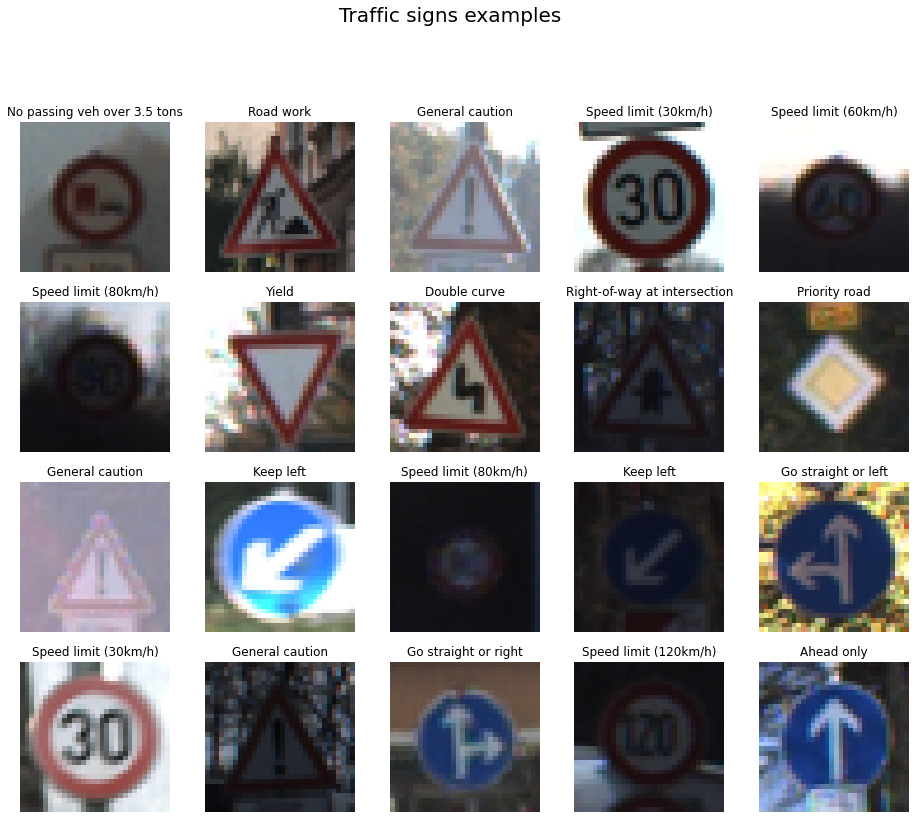

In [9]:
show_20_images(data, labels)

## 2. Rescaling the Pixel Values

All the pixel values on the array are between 0 and 255, so to rescale them to a [0, 1] interval, we can just divide the values by 255.

This is done because neural networks prefer to deal with small input values.

In [9]:
data_normalized = data / 255

## 3. Train-Validation Split

In this stage, we split the training set in training and validation data, with a ratio of 70:30.

In [10]:
X_train, X_val, y_train, y_val = train_test_split(data_normalized, 
                                                  labels, 
                                                  test_size=0.3, 
                                                  random_state=42, 
                                                  shuffle=True)

In [11]:
print("The X_train.shape is", X_train.shape)
print("The X_val.shape is", X_val.shape)
print("The y_train.shape is", y_train.shape)
print("The y_val.shape is", y_val.shape)

The X_train.shape is (27446, 32, 32, 3)
The X_val.shape is (11763, 32, 32, 3)
The y_train.shape is (27446,)
The y_val.shape is (11763,)


## 4. One-Hot Encoding the Labels

This is done to convert the labels with one-hot encoding, using the Keras function "to_categorical".

In [12]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

## 5. Computer Vision Models

In this section, we will use two types of models: 
- firstly, six CNN architectures made by ourselves;
- afterwards, three pre-trained models (VGG16, EfficientNetB7 and ResNet152V2).

**Our CNN Architectures:**

In [15]:
# Simple CNN: Baseline Model.

def cnn_1(input_shape):
    classifier = Sequential()
    
    classifier.add(Conv2D(32, (5, 5), input_shape = input_shape, activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    
    classifier.add(Conv2D(64, (5, 5), activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    
    classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    
    classifier.add(Flatten())

    classifier.add(Dense(units = 512, activation = 'relu'))
    classifier.add(Dense(units = 43, activation = 'softmax'))
    
    return classifier

In [16]:
# Similar to cnn_1, but with Dropout.

def cnn_2(input_shape):
    classifier = Sequential()
    
    classifier.add(Conv2D(32, (5, 5), input_shape = input_shape, activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    classifier.add(Dropout(rate=0.25))
    
    classifier.add(Conv2D(64, (5, 5), activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    classifier.add(Dropout(rate=0.25))
    
    classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    classifier.add(Dropout(rate=0.25))
    
    classifier.add(Flatten())

    classifier.add(Dense(units = 512, activation = 'relu'))
    classifier.add(Dropout(rate=0.5))
    classifier.add(Dense(units = 43, activation = 'softmax'))
    
    return classifier

In [17]:
# Similar to cnn_2, but with BatchNormalization.
# Once implemented, batch normalization has the effect of dramatically accelerating the training process of a neural 
# network, and in some cases improves the performance of the model via a modest regularization effect.

def cnn_3(input_shape):
    classifier = Sequential()
    
    classifier.add(Conv2D(32, (5, 5), input_shape = input_shape, activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(rate=0.25))
    
    classifier.add(Conv2D(64, (5, 5), activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(rate=0.25))
    
    classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(rate=0.25))
    
    classifier.add(Flatten())

    classifier.add(Dense(units = 512, activation = 'relu'))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(rate=0.5))
    classifier.add(Dense(units = 43, activation = 'softmax'))
    
    return classifier

In [13]:
# New CNN, with two conv layers in a row. This is something possible and commonly used in very challenging tasks.
# The idea of having two (or more) conv layers is to perform a more in-depth analysis of local patterns of the image.
# There is no rule for deciding if two consecutive conv layers are better than a conv layer followed by a pooling layer.

def cnn_4(input_shape):
    classifier = Sequential()
    
    classifier.add(Conv2D(16, (5, 5), input_shape = input_shape, activation = 'relu'))
    classifier.add(Conv2D(32, (5, 5), activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(rate=0.25))
    
    classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
    classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(rate=0.25))
    
    classifier.add(Flatten())

    classifier.add(Dense(units = 512, activation = 'relu'))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(rate=0.5))
    classifier.add(Dense(units = 43, activation = 'softmax'))
    
    return classifier

In [19]:
# Similar to cnn_4, but with the same number of filters on the 2 first, and 2 last, conv layers. 
# Also, it has regularizers (L1 and L2).

l1_cnn_5 = 0.001
l2_cnn_5 = 0.001

def cnn_5(input_shape):
    classifier = Sequential()
    
    classifier.add(Conv2D(32, (5, 5), input_shape = input_shape, activation = 'relu', kernel_regularizer = l1_l2(l1=l1_cnn_5, l2=l2_cnn_5)))
    classifier.add(Conv2D(32, (5, 5), activation = 'relu', kernel_regularizer = l1_l2(l1=l1_cnn_5, l2=l2_cnn_5)))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(rate=0.25))
    
    classifier.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l1_l2(l1=l1_cnn_5, l2=l2_cnn_5)))
    classifier.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = l1_l2(l1=l1_cnn_5, l2=l2_cnn_5)))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(rate=0.25))
    
    classifier.add(Flatten())

    classifier.add(Dense(units = 512, activation = 'relu'))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(rate=0.5))
    classifier.add(Dense(units = 43, activation = 'softmax'))
    
    return classifier

In [20]:
# Similar to cnn_3, but with 256 units in the fully-connected layer, and 64 batches in the fit.

def cnn_6(input_shape):
    classifier = Sequential()
    
    classifier.add(Conv2D(32, (5, 5), input_shape = input_shape, activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(rate=0.25))
    
    classifier.add(Conv2D(64, (5, 5), activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(rate=0.25))
    
    classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(rate=0.25))
    
    classifier.add(Flatten())

    classifier.add(Dense(units = 256, activation = 'relu'))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(rate=0.5))
    classifier.add(Dense(units = 43, activation = 'softmax'))
    
    return classifier

**Pre-trained Models:**

Three of the best and more popular models for Transfer Learning are as follows:

- VGG (we will use VGG16); <br>
- EfficientNet (we will use EfficientNetB7); <br>
- Residual Network (we will use ResNet152V2).

In this Transfer Learning phase, we will train only the fully-connected layer, so the rest of the model's weights will stay frozen. Also, we added our own custom classifier on the fully-connected layers of the 3 models.

In [27]:
# VGG16
vgg = VGG16(input_shape=(32,32,3),
            weights='imagenet', 
            include_top=False)

# Don't train existing weights
for layer in vgg.layers:
    layer.trainable = False
    
# Add a custom fully-connected layer
x = Flatten()(vgg.output)

x = Dense(units = 512, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.5)(x)
x = Dense(units = 43, activation='softmax')(x)

In [28]:
# EfficientNetB7
e_net = EfficientNetB7(input_shape=(32,32,3),
                       weights='imagenet', 
                       include_top=False)

# Don't train existing weights
for layer in e_net.layers:
    layer.trainable = False
    
# Add a custom fully-connected layer
y = Flatten()(e_net.output)

y = Dense(units = 512, activation = 'relu')(y)
y = BatchNormalization()(y)
y = Dropout(rate=0.5)(y)
y = Dense(units = 43, activation='softmax')(y)

In [29]:
# ResNet152V2
resnet = ResNet152V2(input_shape=(32,32,3),
                     weights='imagenet', 
                     include_top=False)

# Don't train existing weights
for layer in resnet.layers:
    layer.trainable = False
    
# Add a custom fully-connected layer
z = Flatten()(resnet.output)

z = Dense(units = 512, activation = 'relu')(z)
z = BatchNormalization()(z)
z = Dropout(rate=0.5)(z)
z = Dense(units = 43, activation='softmax')(z)

### 5.1. Data Augmentation

To avoid overfitting and to improve the generalizability of our models, we'll use data augmentation.

It's important to note rotations and flips can potentially harm the quality of the model (some signs look like others if they are flipped), so we will pay special attention to those parameters.

In [14]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

### 5.2. Callbacks

In [15]:
callbacks_list = [
    keras.callbacks.EarlyStopping( # Once triggered, stops the training (if the val_accuracy decreases 5 epochs in a row).
        monitor='val_accuracy',
        patience=5),
    keras.callbacks.ModelCheckpoint( # Saves the best model observed during training (according to val_loss).
        filepath = 'cnn_model_file',
        monitor='val_loss',
        save_best_only=True)
]

### 5.3. Compile and Fit

**Our CNN Architectures:**

**a) cnn_1:**

In [26]:
# Get the model
cnn_1_model = cnn_1((32,32,3))

# Compile
opt = optimizers.RMSprop(lr = 1e-4)

cnn_1_model.compile(loss='categorical_crossentropy', 
                    optimizer=opt, 
                    metrics=['accuracy'])

# Fit
epochs = 30

history_1 = cnn_1_model.fit(aug.flow(X_train, y_train, batch_size=32),
                            epochs=epochs, 
                            callbacks=callbacks_list,
                            validation_data=(X_val, y_val))

Epoch 1/30
857/858 [============================>.] - ETA: 0s - loss: 3.3042 - accuracy: 0.1194WARNING:tensorflow:From C:\Users\ruifi\anaconda3\envs\DLclasses\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: cnn_model_file\assets
858/858 [==============================] - 50s 58ms/step - loss: 3.3040 - accuracy: 0.1195 - val_loss: 2.9484 - val_accuracy: 0.2155
Epoch 2/30
858/858 [==============================] - 50s 58ms/step - loss: 2.8111 - accuracy: 0.2344 - val_loss: 2.4562 - val_accuracy: 0.3042
Epoch 3/30
858/858 [==============================] - 49s 57ms/step - loss: 2.41

Epoch 28/30
858/858 [==============================] - 50s 58ms/step - loss: 0.2822 - accuracy: 0.9171 - val_loss: 0.0930 - val_accuracy: 0.9772
Epoch 29/30
858/858 [==============================] - 45s 52ms/step - loss: 0.2759 - accuracy: 0.9198 - val_loss: 0.0932 - val_accuracy: 0.9774
Epoch 30/30
858/858 [==============================] - 45s 53ms/step - loss: 0.2647 - accuracy: 0.9239 - val_loss: 0.1075 - val_accuracy: 0.9685


In [27]:
# Model summary
cnn_1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        2432      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0

**b) cnn_2:**

In [38]:
# Get the model
cnn_2_model = cnn_2((32,32,3))

# Compile
opt = optimizers.RMSprop(lr = 1e-4)

cnn_2_model.compile(loss='categorical_crossentropy', 
                    optimizer=opt, 
                    metrics=['accuracy'])

# Fit
epochs = 30

history_2 = cnn_2_model.fit(aug.flow(X_train, y_train, batch_size=32),
                            epochs=epochs, 
                            callbacks=callbacks_list,
                            validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 48s 56ms/step - loss: 3.5147 - accuracy: 0.0685 - val_loss: 3.3113 - val_accuracy: 0.1565
Epoch 2/30
858/858 [==============================] - 52s 61ms/step - loss: 3.1244 - accuracy: 0.1484 - val_loss: 2.8204 - val_accuracy: 0.2459
Epoch 3/30
858/858 [==============================] - 50s 58ms/step - loss: 2.7675 - accuracy: 0.2251 - val_loss: 2.3492 - val_accuracy: 0.3468
Epoch 4/30
858/858 [==============================] - 49s 57ms/step - loss: 2.4186 - accuracy: 0.3008 - val_loss: 1.9941 - val_accuracy: 0.3958
Epoch 5/30
858/858 [==============================] - 49s 57ms/step - loss: 2.1657 - accuracy: 0.3494 - val_loss: 1.7530 - val_accuracy: 0.4401
Epoch 6/30
858/858 [==============================] - 49s 57ms/step - loss: 1.9655 - accuracy: 0.3889 - val_loss: 1.5688 - val_accuracy: 0.4772
Epoch 7/30
858/858 [==============================] - 49s 58ms/step - loss: 1.8182 - accuracy: 0.4231 - val_loss: 1.4645 - val_accuracy:

In [39]:
# Model summary
cnn_2_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        2432      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 128)        

**c) cnn_3:**

In [44]:
# Get the model
cnn_3_model = cnn_3((32,32,3))

# Compile
opt = optimizers.Adam() # https://keras.io/api/optimizers/adam/

cnn_3_model.compile(loss='categorical_crossentropy', 
                    optimizer=opt, 
                    metrics=['accuracy'])

# Fit
epochs = 30

history_3 = cnn_3_model.fit(aug.flow(X_train, y_train, batch_size=32),
                            epochs=epochs, 
                            callbacks=callbacks_list,
                            validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 53s 62ms/step - loss: 2.7012 - accuracy: 0.3015 - val_loss: 0.9850 - val_accuracy: 0.6673
Epoch 2/30
858/858 [==============================] - 54s 63ms/step - loss: 1.2364 - accuracy: 0.6158 - val_loss: 0.3858 - val_accuracy: 0.8832
Epoch 3/30
858/858 [==============================] - 54s 63ms/step - loss: 0.8300 - accuracy: 0.7395 - val_loss: 0.2049 - val_accuracy: 0.9378
Epoch 4/30
858/858 [==============================] - 54s 63ms/step - loss: 0.6481 - accuracy: 0.7951 - val_loss: 0.1085 - val_accuracy: 0.9709
Epoch 5/30
858/858 [==============================] - 58s 67ms/step - loss: 0.5525 - accuracy: 0.8249 - val_loss: 0.0965 - val_accuracy: 0.9776
Epoch 6/30
858/858 [==============================] - 67s 78ms/step - loss: 0.4941 - accuracy: 0.8459 - val_loss: 0.0778 - val_accuracy: 0.9768
Epoch 7/30
858/858 [==============================] - 59s 68ms/step - loss: 0.4580 - accuracy: 0.8572 - val_loss: 0.0819 - val_accuracy:

In [45]:
# Model summary
cnn_3_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        2432      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 64)        51264     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 5, 5, 64)         

**d) cnn_4:**

In [16]:
# Get the model
cnn_4_model = cnn_4((32,32,3))

# Compile
opt = optimizers.Adam()

cnn_4_model.compile(loss='categorical_crossentropy', 
                    optimizer=opt, 
                    metrics=['accuracy'])

# Fit
epochs = 30

history_4 = cnn_4_model.fit(aug.flow(X_train, y_train, batch_size=32),
                            epochs=epochs, 
                            callbacks=callbacks_list,
                            validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - ETA: 0s - loss: 2.0595 - accuracy: 0.4515WARNING:tensorflow:From C:\Users\ruifi\anaconda3\envs\DLclasses\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: cnn_model_file\assets
858/858 [==============================] - 97s 113ms/step - loss: 2.0595 - accuracy: 0.4515 - val_loss: 0.5383 - val_accuracy: 0.8148
Epoch 2/30
858/858 [==============================] - 99s 115ms/step - loss: 0.6219 - accuracy: 0.8073 - val_loss: 0.0768 - val_accuracy: 0.9778
Epoch 3/30
858/858 [==============================] - 94s 109ms/step - loss: 0

In [17]:
# Model summary
cnn_4_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        1216      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        12832     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         7

**e) cnn_5:**

In [56]:
# Get the model
cnn_5_model = cnn_5((32,32,3))

# Compile
opt = optimizers.Adam()

cnn_5_model.compile(loss='categorical_crossentropy', 
                    optimizer=opt, 
                    metrics=['accuracy'])

# Fit
epochs = 30

history_5 = cnn_5_model.fit(aug.flow(X_train, y_train, batch_size=32),
                            epochs=epochs, 
                            callbacks=callbacks_list,
                            validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 107s 125ms/step - loss: 4.3509 - accuracy: 0.3485 - val_loss: 1.9155 - val_accuracy: 0.7624
Epoch 2/30
858/858 [==============================] - 109s 127ms/step - loss: 1.8739 - accuracy: 0.6925 - val_loss: 1.1354 - val_accuracy: 0.8771
Epoch 3/30
858/858 [==============================] - 110s 129ms/step - loss: 1.2625 - accuracy: 0.8151 - val_loss: 0.7504 - val_accuracy: 0.9545
Epoch 4/30
858/858 [==============================] - 111s 129ms/step - loss: 1.0440 - accuracy: 0.8537 - val_loss: 0.7076 - val_accuracy: 0.9523
Epoch 5/30
858/858 [==============================] - 113s 131ms/step - loss: 0.9501 - accuracy: 0.8695 - val_loss: 0.6738 - val_accuracy: 0.9495
Epoch 6/30
858/858 [==============================] - 110s 129ms/step - loss: 0.8722 - accuracy: 0.8883 - val_loss: 0.5736 - val_accuracy: 0.9774
Epoch 7/30
858/858 [==============================] - 111s 129ms/step - loss: 0.8505 - accuracy: 0.8908 - val_loss: 0.5532 -

In [57]:
# Model summary
cnn_5_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 32)        25632     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_14 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 64)         

**f) cnn_6:**

In [62]:
# Get the model
cnn_6_model = cnn_6((32,32,3))

# Compile
opt = optimizers.Adam()

cnn_6_model.compile(loss='categorical_crossentropy', 
                    optimizer=opt, 
                    metrics=['accuracy'])

# Fit
epochs = 30

history_6 = cnn_6_model.fit(aug.flow(X_train, y_train, batch_size=64), # 64 batches!
                            epochs=epochs, 
                            callbacks=callbacks_list,
                            validation_data=(X_val, y_val))

Epoch 1/30
429/429 [==============================] - 50s 116ms/step - loss: 2.8196 - accuracy: 0.2709 - val_loss: 3.2812 - val_accuracy: 0.1421
Epoch 2/30
429/429 [==============================] - 51s 118ms/step - loss: 1.4091 - accuracy: 0.5604 - val_loss: 0.5199 - val_accuracy: 0.8379
Epoch 3/30
429/429 [==============================] - 51s 119ms/step - loss: 0.9155 - accuracy: 0.7113 - val_loss: 0.2761 - val_accuracy: 0.9201
Epoch 4/30
429/429 [==============================] - 51s 120ms/step - loss: 0.6851 - accuracy: 0.7842 - val_loss: 0.1436 - val_accuracy: 0.9605
Epoch 5/30
429/429 [==============================] - 52s 121ms/step - loss: 0.5569 - accuracy: 0.8263 - val_loss: 0.1923 - val_accuracy: 0.9391
Epoch 6/30
429/429 [==============================] - 54s 125ms/step - loss: 0.4696 - accuracy: 0.8510 - val_loss: 0.1172 - val_accuracy: 0.9668
Epoch 7/30
429/429 [==============================] - 52s 122ms/step - loss: 0.4059 - accuracy: 0.8730 - val_loss: 0.0597 - val_ac

In [63]:
# Model summary
cnn_6_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 28, 28, 32)        2432      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
dropout_17 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 10, 10, 64)        51264     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 5, 5, 64)         

**Pre-trained Models:**

**a) VGG16:**

In [30]:
# Get the model
vgg_model = Model(inputs=vgg.input, outputs=x)

# Compile
opt = optimizers.Adam()

vgg_model.compile(loss='categorical_crossentropy', 
                  optimizer=opt, 
                  metrics=['accuracy'])

# Fit
epochs = 5 # Less epochs, because only the fully-connected layer will be trained

history_vgg = vgg_model.fit(aug.flow(X_train, y_train, batch_size=32),
                            epochs=epochs, 
                            callbacks=callbacks_list,
                            validation_data=(X_val, y_val))

Epoch 1/5
858/858 [==============================] - 236s 276ms/step - loss: 2.0937 - accuracy: 0.3973 - val_loss: 1.4035 - val_accuracy: 0.5440
Epoch 2/5
858/858 [==============================] - 239s 279ms/step - loss: 1.5937 - accuracy: 0.4998 - val_loss: 1.2867 - val_accuracy: 0.5812
Epoch 3/5
858/858 [==============================] - 237s 276ms/step - loss: 1.4792 - accuracy: 0.5290 - val_loss: 1.1762 - val_accuracy: 0.6202
Epoch 4/5
858/858 [==============================] - 235s 274ms/step - loss: 1.4288 - accuracy: 0.5456 - val_loss: 1.1813 - val_accuracy: 0.6200 1.4
Epoch 5/5
858/858 [==============================] - 237s 276ms/step - loss: 1.3803 - accuracy: 0.5580 - val_loss: 1.1085 - val_accuracy: 0.6365


**b) EfficientNetB7:**

In [31]:
# Get the model
e_net_model = Model(inputs=e_net.input, outputs=y)

# Compile
opt = optimizers.Adam()

e_net_model.compile(loss='categorical_crossentropy', 
                    optimizer=opt, 
                    metrics=['accuracy'])

# Fit
epochs = 5 # Less epochs, because only the fully-connected layer will be trained

history_e_net = e_net_model.fit(aug.flow(X_train, y_train, batch_size=32),
                                epochs=epochs, 
                                callbacks=callbacks_list,
                                validation_data=(X_val, y_val))

Epoch 1/5
858/858 [==============================] - 399s 465ms/step - loss: 3.7749 - accuracy: 0.0492 - val_loss: 3.5311 - val_accuracy: 0.0583
Epoch 2/5
858/858 [==============================] - 394s 459ms/step - loss: 3.6143 - accuracy: 0.0512 - val_loss: 3.5166 - val_accuracy: 0.0478
Epoch 3/5
858/858 [==============================] - 400s 466ms/step - loss: 3.5734 - accuracy: 0.0551 - val_loss: 3.5001 - val_accuracy: 0.0473
Epoch 4/5
858/858 [==============================] - 397s 463ms/step - loss: 3.5472 - accuracy: 0.0498 - val_loss: 3.5039 - val_accuracy: 0.0583
Epoch 5/5
858/858 [==============================] - 396s 461ms/step - loss: 3.5407 - accuracy: 0.0531 - val_loss: 3.5038 - val_accuracy: 0.0550


**c) ResNet152V2:**

In [61]:
# Get the model
resnet_model = Model(inputs=resnet.input, outputs=z)

# Compile
opt = optimizers.Adam()

resnet_model.compile(loss='categorical_crossentropy', 
                     optimizer=opt, 
                     metrics=['accuracy'])

# Fit
epochs = 5 # Less epochs, because only the fully-connected layer will be trained

history_resnet = resnet_model.fit(aug.flow(X_train, y_train, batch_size=32),
                                  epochs=epochs, 
                                  callbacks=callbacks_list,
                                  validation_data=(X_val, y_val))

Epoch 1/5
858/858 [==============================] - 293s 341ms/step - loss: 2.8675 - accuracy: 0.2502 - val_loss: 2.0493 - val_accuracy: 0.3840
Epoch 2/5
858/858 [==============================] - 287s 334ms/step - loss: 2.3089 - accuracy: 0.3271 - val_loss: 1.9001 - val_accuracy: 0.4210
Epoch 3/5
858/858 [==============================] - 290s 338ms/step - loss: 2.1644 - accuracy: 0.3503 - val_loss: 1.8266 - val_accuracy: 0.4343
Epoch 4/5
858/858 [==============================] - 286s 334ms/step - loss: 2.0789 - accuracy: 0.3693 - val_loss: 1.7675 - val_accuracy: 0.4561
Epoch 5/5
858/858 [==============================] - 288s 336ms/step - loss: 2.0290 - accuracy: 0.3832 - val_loss: 1.7517 - val_accuracy: 0.4534


As it can be seen by the three previous outputs, the pre-trained models had very weak performances in general, and specifically in the validation accuracy. Thus, we will perform the predictions on the test dataset using one of our CNN architectures, so we won't be showing any more metrics for these three transfer learning models (i.e. VGG16, EfficientNetB7, and ResNet152V2) in the next sections of this Notebook.

## 6. Evaluating the Models

In [18]:
def plot_loss_acc(hist, max_lim=3.5, cnn_x=''):
    """
    Displays a plot with the accuracy and loss over the training of a specific CNN. The four lines on the line chart 
    represent the training loss, training accuracy, validation loss, and validation accuracy, respectively.
    """
    pd.DataFrame(hist.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, max_lim)

    plt.title('Accuracy and Loss: ' + cnn_x, size=20)
    plt.xlabel('epochs')

    plt.show()

**Our CNN Architectures:**

**a) cnn_1:**

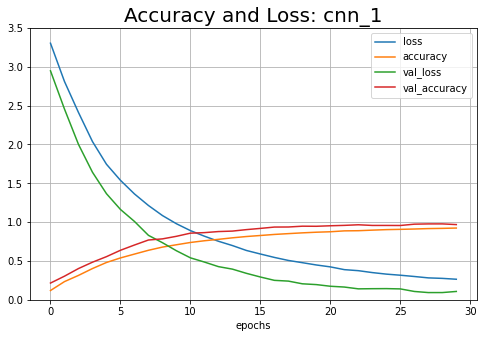

In [31]:
plot_loss_acc(history_1, cnn_x='cnn_1')

**b) cnn_2:**

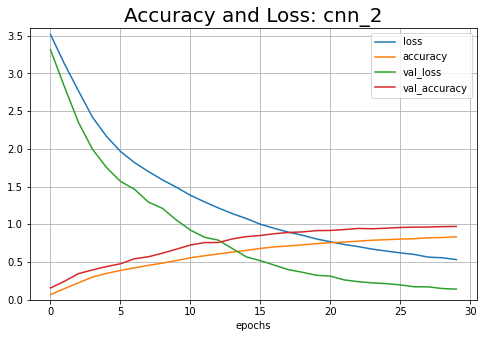

In [40]:
plot_loss_acc(history_2, 3.6, 'cnn_2')

**c) cnn_3:**

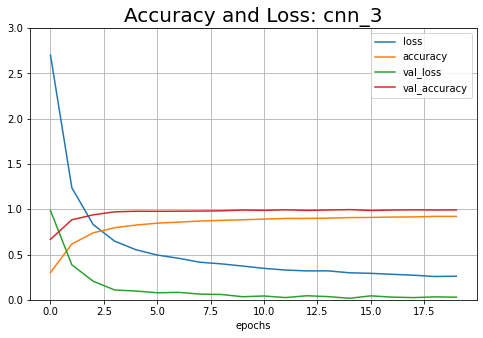

In [46]:
plot_loss_acc(history_3, 3, 'cnn_3')

**d) cnn_4:**

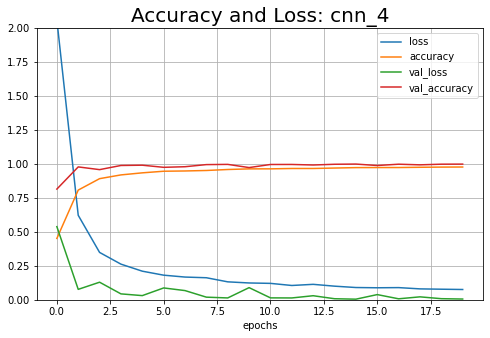

In [19]:
plot_loss_acc(history_4, 2, 'cnn_4')

**e) cnn_5:**

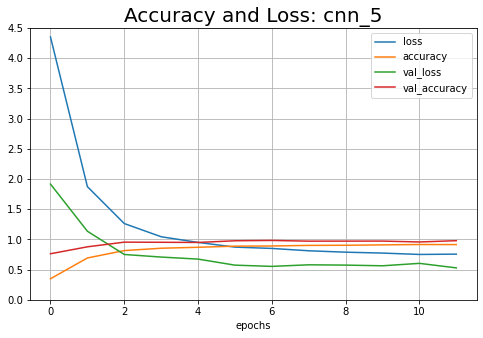

In [58]:
plot_loss_acc(history_5, 4.5, 'cnn_5')

**f) cnn_6:**

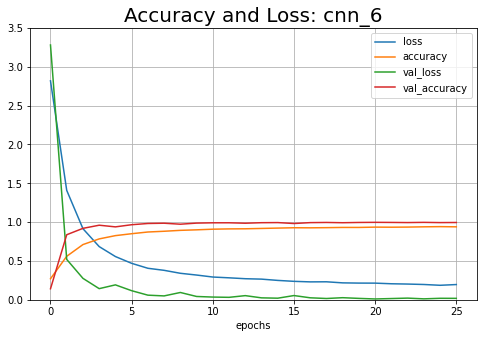

In [65]:
plot_loss_acc(history_6, cnn_x='cnn_6')

## 7. Importing the Test dataset

In [20]:
y_test = pd.read_csv('Test.csv')
labels_test = y_test["ClassId"].values
imgs = y_test["Path"].values
data_test = []

for img in imgs:
    image = Image.open(img)
    image = image.resize((32,32)) # Resizing the images to 32x32
    data_test.append(np.array(image))
    
X_test = np.array(data_test)

In [21]:
# Check data shape (3 colour channels: Red, Green, Blue -> RGB)
print(X_test.shape, labels_test.shape)

(12630, 32, 32, 3) (12630,)


In [22]:
# Rescaling the Pixel Values
X_test = X_test / 255

## 8. Making Predictions and Checking the Metrics

This section presents the Test dataset accuracy and also the precision, recall, F1-score and support for each of the 43 classes. 

This is shown for all six CNN architectures.

As we'll be able to see, the fourth CNN (cnn_4) has the highest test dataset accuracy, and best performance overall. Thus, we can say this was our best model to classify the traffic sign images.

**a) cnn_1:**

In [35]:
# Prediction with the first CNN (cnn_1_model)
pred_1 = cnn_1_model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [36]:
print('Test Dataset accuracy:', round(accuracy_score(labels_test, pred_1)*100, 2))

Test Dataset accuracy: 90.38


In [37]:
print(classification_report(labels_test, pred_1))

              precision    recall  f1-score   support

           0       0.89      0.27      0.41        60
           1       0.91      0.94      0.93       720
           2       0.84      0.97      0.90       750
           3       0.90      0.88      0.89       450
           4       0.90      0.94      0.92       660
           5       0.82      0.88      0.85       630
           6       0.99      0.88      0.93       150
           7       0.97      0.84      0.90       450
           8       0.93      0.85      0.89       450
           9       0.96      0.96      0.96       480
          10       1.00      0.95      0.97       660
          11       0.87      0.88      0.87       420
          12       1.00      0.94      0.97       690
          13       1.00      0.97      0.99       720
          14       0.85      1.00      0.92       270
          15       1.00      0.97      0.98       210
          16       0.95      1.00      0.97       150
          17       1.00    

**b) cnn_2:**

In [41]:
# Prediction with the second CNN (cnn_2_model)
pred_2 = cnn_2_model.predict_classes(X_test)

In [42]:
print('Test Dataset accuracy:', round(accuracy_score(labels_test, pred_2)*100, 2))

Test Dataset accuracy: 92.74


In [43]:
print(classification_report(labels_test, pred_2))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        60
           1       0.88      1.00      0.94       720
           2       0.95      0.94      0.94       750
           3       0.98      0.92      0.95       450
           4       0.99      0.90      0.94       660
           5       0.92      0.92      0.92       630
           6       0.99      0.97      0.98       150
           7       0.98      0.90      0.93       450
           8       0.91      0.97      0.94       450
           9       0.97      1.00      0.99       480
          10       0.99      0.99      0.99       660
          11       0.94      0.92      0.93       420
          12       1.00      0.97      0.99       690
          13       1.00      1.00      1.00       720
          14       0.94      1.00      0.97       270
          15       0.98      0.99      0.98       210
          16       0.89      1.00      0.94       150
          17       1.00    

**c) cnn_3:**

In [47]:
# Prediction with the third CNN (cnn_3_model)
pred_3 = cnn_3_model.predict_classes(X_test)

In [48]:
print('Test Dataset accuracy:', round(accuracy_score(labels_test, pred_3)*100, 2))

Test Dataset accuracy: 95.65


In [49]:
print(classification_report(labels_test, pred_3))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        60
           1       0.96      0.98      0.97       720
           2       0.98      0.97      0.97       750
           3       0.99      0.93      0.96       450
           4       0.99      0.96      0.98       660
           5       0.89      0.99      0.94       630
           6       0.99      0.95      0.97       150
           7       0.99      0.97      0.98       450
           8       1.00      0.95      0.97       450
           9       1.00      1.00      1.00       480
          10       0.99      0.99      0.99       660
          11       1.00      0.96      0.98       420
          12       0.98      0.92      0.95       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      1.00       270
          15       0.96      1.00      0.98       210
          16       1.00      1.00      1.00       150
          17       1.00    

**d) cnn_4:**

In [23]:
# Prediction with the fourth CNN (cnn_4_model)
pred_4 = cnn_4_model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [24]:
print('Test Dataset accuracy:', round(accuracy_score(labels_test, pred_4)*100, 2))

Test Dataset accuracy: 97.6


In [25]:
print(classification_report(labels_test, pred_4))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00       720
           2       1.00      1.00      1.00       750
           3       0.95      0.98      0.96       450
           4       0.99      1.00      0.99       660
           5       0.97      1.00      0.98       630
           6       0.96      0.89      0.93       150
           7       1.00      0.98      0.99       450
           8       1.00      0.98      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.98      0.94      0.96       420
          12       1.00      0.94      0.97       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.86      1.00      0.93       210
          16       0.99      1.00      1.00       150
          17       1.00    

**e) cnn_5:**

In [59]:
# Prediction with the fifth CNN (cnn_5_model)
pred_5 = cnn_5_model.predict_classes(X_test)

In [60]:
print('Test Dataset accuracy:', round(accuracy_score(labels_test, pred_5)*100, 2))

Test Dataset accuracy: 94.17


In [61]:
print(classification_report(labels_test, pred_5))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       0.97      1.00      0.98       720
           2       0.95      0.99      0.97       750
           3       0.97      0.89      0.93       450
           4       0.98      0.98      0.98       660
           5       0.92      0.95      0.94       630
           6       1.00      0.89      0.94       150
           7       0.91      0.99      0.95       450
           8       0.99      0.96      0.98       450
           9       0.96      1.00      0.98       480
          10       0.99      1.00      1.00       660
          11       0.97      0.91      0.94       420
          12       0.99      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       0.91      1.00      0.95       270
          15       0.93      1.00      0.96       210
          16       1.00      1.00      1.00       150
          17       1.00    

**f) cnn_6:**

In [66]:
# Prediction with the sixth CNN (cnn_6_model)
pred_6 = cnn_6_model.predict_classes(X_test)

In [67]:
print('Test Dataset accuracy:', round(accuracy_score(labels_test, pred_6)*100, 2))

Test Dataset accuracy: 96.61


In [68]:
print(classification_report(labels_test, pred_6))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98        60
           1       0.92      0.99      0.96       720
           2       0.98      0.96      0.97       750
           3       1.00      0.91      0.95       450
           4       0.98      0.97      0.97       660
           5       0.93      0.95      0.94       630
           6       1.00      0.98      0.99       150
           7       1.00      0.88      0.94       450
           8       0.88      1.00      0.93       450
           9       1.00      1.00      1.00       480
          10       0.99      1.00      0.99       660
          11       0.97      1.00      0.98       420
          12       0.99      0.97      0.98       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      0.99       270
          15       0.99      1.00      0.99       210
          16       0.99      1.00      1.00       150
          17       1.00    

## 9. Save the Best CNN Model

In [26]:
cnn_4_model.save('traffic_signs_classifier.h5')

## Code References

Importing the Data: <br>
https://data-flair.training/blogs/python-project-traffic-signs-recognition/

Transfer Learning: <br>
https://github.com/krishnaik06/Transfer-Learning/blob/master/face_Recognition.py